## Valorant Average Combat Score Prediction Using Dense Neural Network Based on Match Metrics

**Proponents:** *Alforque, Batalan, Verdan*

### Phase 1: Pre-processing

#### Import modules

In [383]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics


#### Define path

In [384]:
DATASET_PATH = "data/dataset.csv"
df = pd.read_csv(DATASET_PATH)
df = df[df['side'] != 'both']
df = df[df['map'] != 'All Maps']
df = df.dropna(subset=['rating', 'acs'])
df['kast_percent'] = df['kast_percent'].str.rstrip('%').astype(float) / 100
df['headshot_percent'] = df['headshot_percent'].str.rstrip('%').astype(float) / 100

In [385]:
df.shape[0]

31700

In [386]:
df.isna().any()

tourney             False
stage               False
match_type          False
match_name          False
map                 False
player              False
team                False
agents              False
rating              False
acs                 False
kills               False
deaths              False
assists             False
kd                   True
kast_percent         True
adpr                 True
headshot_percent     True
firstkill           False
firstdeath          False
fkd                 False
side                False
team_win            False
dtype: bool

#### Extract labels

In [387]:
y = df['team_win'].values
len(y)

31700

#### Select features

In [388]:
features = ['kills','deaths','assists','kast_percent','headshot_percent','adpr','firstkill','firstdeath']
X_raw = df[features].copy()
X_raw.head(5)

,kills,deaths,assists,kast_percent,headshot_percent,adpr,firstkill,firstdeath
1,12.0,5.0,2.0,0.89,0.37,216.0,2.0,2.0
2,12.0,7.0,2.0,0.75,0.24,168.0,1.0,2.0
4,8.0,4.0,1.0,0.78,0.35,127.0,1.0,1.0
5,9.0,6.0,3.0,0.75,0.23,150.0,0.0,3.0
7,5.0,3.0,3.0,0.89,0.19,96.0,0.0,0.0


In [389]:
X_raw.shape[0]

31700

#### Check for missing data

In [390]:
X_raw.isna().any()

kills               False
deaths              False
assists             False
kast_percent         True
headshot_percent     True
adpr                 True
firstkill           False
firstdeath          False
dtype: bool

#### Impute missing data

In [391]:
X_raw['adpr'].interpolate(method='linear', axis=0, inplace=True)
X_raw['kast_percent'].interpolate(method='linear', axis=0, inplace=True)
X_raw['headshot_percent'].interpolate(method='linear', axis=0, inplace=True)

C:\Users\hi\AppData\Local\Temp\ipykernel_12068\583741011.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_raw['adpr'].interpolate(method='linear', axis=0, inplace=True)
C:\Users\hi\AppData\Local\Temp\ipykernel_12068\583741011.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


In [392]:
X_raw.isna().any()

kills               False
deaths              False
assists             False
kast_percent        False
headshot_percent    False
adpr                False
firstkill           False
firstdeath          False
dtype: bool

#### Split data

In [393]:
train_X_raw, test_X_raw, train_y, test_y = train_test_split(X_raw, y, test_size=0.2, stratify=y, random_state=42)
print(f'train_X_raw: {train_X_raw.shape}')
print(f'test_X_raw: {test_X_raw.shape}')
print(f'train_y: {train_y.shape}')
print(f'test_y: {test_y.shape}')

train_X_raw: (25360, 8)
test_X_raw: (6340, 8)
train_y: (25360,)
test_y: (6340,)


#### Define encoders

In [394]:
encoders = ColumnTransformer([
    ('scaler', StandardScaler(), ['kills','deaths','assists','kast_percent','headshot_percent','adpr','firstkill','firstdeath'])
])

#### Encode training data

In [395]:
train_X = encoders.fit_transform(train_X_raw)

In [396]:
train_X.shape

(25360, 8)

#### Encode test data

In [397]:
test_X = encoders.transform(test_X_raw)

In [398]:
test_X.shape

(6340, 8)

### Phase II: Neural Network Architecture and Rationale

#### Create Keras model

In [399]:
input_ = tf.keras.layers.Input(shape=(8,))
dense1 = tf.keras.layers.Dense(256, activation='relu')(input_)
reg1 = dense1
reg1 = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(512, activation='relu')(reg1)
reg2 = dense2
reg2 = tf.keras.layers.BatchNormalization()(dense2)
dense3 = tf.keras.layers.Dense(512, activation='relu')(reg2)
reg3 = dense3
reg3 = tf.keras.layers.BatchNormalization()(dense3)
dense4 = tf.keras.layers.Dense(256, activation='relu')(reg3)
reg4 = dense4
reg4 = tf.keras.layers.BatchNormalization()(dense4)
dense5 = tf.keras.layers.Dense(128, activation='relu')(reg4)
reg5 = dense5
reg5 = tf.keras.layers.BatchNormalization()(dense5)
output = tf.keras.layers.Dense(1, activation='sigmoid')(reg5)


In [400]:
model = tf.keras.Model(inputs=input_, outputs=output)

In [401]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,553 (2.17 MB)

 Trainable params: 564,225 (2.15 MB)

 Non-trainable params: 3,328 (13.00 KB)

### Phase III: Training Methods

#### Compile model

In [402]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy','precision','recall']
)

#### Define early stop

In [403]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)

#### Define model checkpoint

In [404]:
MODEL_PATH = 'fpcheckpoint2/checkpoints_it_11/model_at_{epoch:02d}.keras'
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(MODEL_PATH)

#### Train model

In [405]:
training_history = model.fit(train_X, train_y, batch_size=32, epochs=20, validation_split=0.2, callbacks=[early_stop, model_checkpoint])

Epoch 1/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5820 - loss: 0.7209 - precision: 0.5796 - recall: 0.5556 - val_accuracy: 0.6173 - val_loss: 0.6673 - val_precision: 0.6135 - val_recall: 0.6488
Epoch 2/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6168 - loss: 0.6551 - precision: 0.6193 - recall: 0.6120 - val_accuracy: 0.6339 - val_loss: 0.6470 - val_precision: 0.6336 - val_recall: 0.6472
Epoch 3/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6277 - loss: 0.6498 - precision: 0.6303 - recall: 0.6293 - val_accuracy: 0.6240 - val_loss: 0.6481 - val_precision: 0.6129 - val_recall: 0.6875
Epoch 4/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6283 - loss: 0.6497 - precision: 0.6232 - recall: 0.6324 - val_accuracy: 0.6252 - val_loss: 0.6392 - val_precision: 0.6467 - val_recall: 0.5634
Epoch 5/20
634/634 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6301 - loss: 0.6469 - precision: 0.6336 - recall: 0.6230 - val_accuracy: 0.6305 - val_l

#### Save model

In [406]:
SAVED_MODEL_PATH = 'fpcheckpoint2/checkpoints_it_11/model.keras'
model.save(SAVED_MODEL_PATH)

### Phase IV: Post Processing

#### Load and verify model

In [407]:
saved_model = tf.keras.models.load_model(SAVED_MODEL_PATH)
saved_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,696,005 (6.47 MB)

 Trainable params: 564,225 (2.15 MB)

 Non-trainable params: 3,328 (13.00 KB)

 Optimizer params: 1,128,452 (4.30 MB)

#### Consume best model

In [408]:
y_pred_prob = saved_model.predict(test_X)
y_pred = (y_pred_prob > 0.5).astype(int)

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [409]:
results = saved_model.evaluate(test_X, test_y, verbose=1)

199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6256 - loss: 0.6438 - precision: 0.6460 - recall: 0.5729


#### Plot model

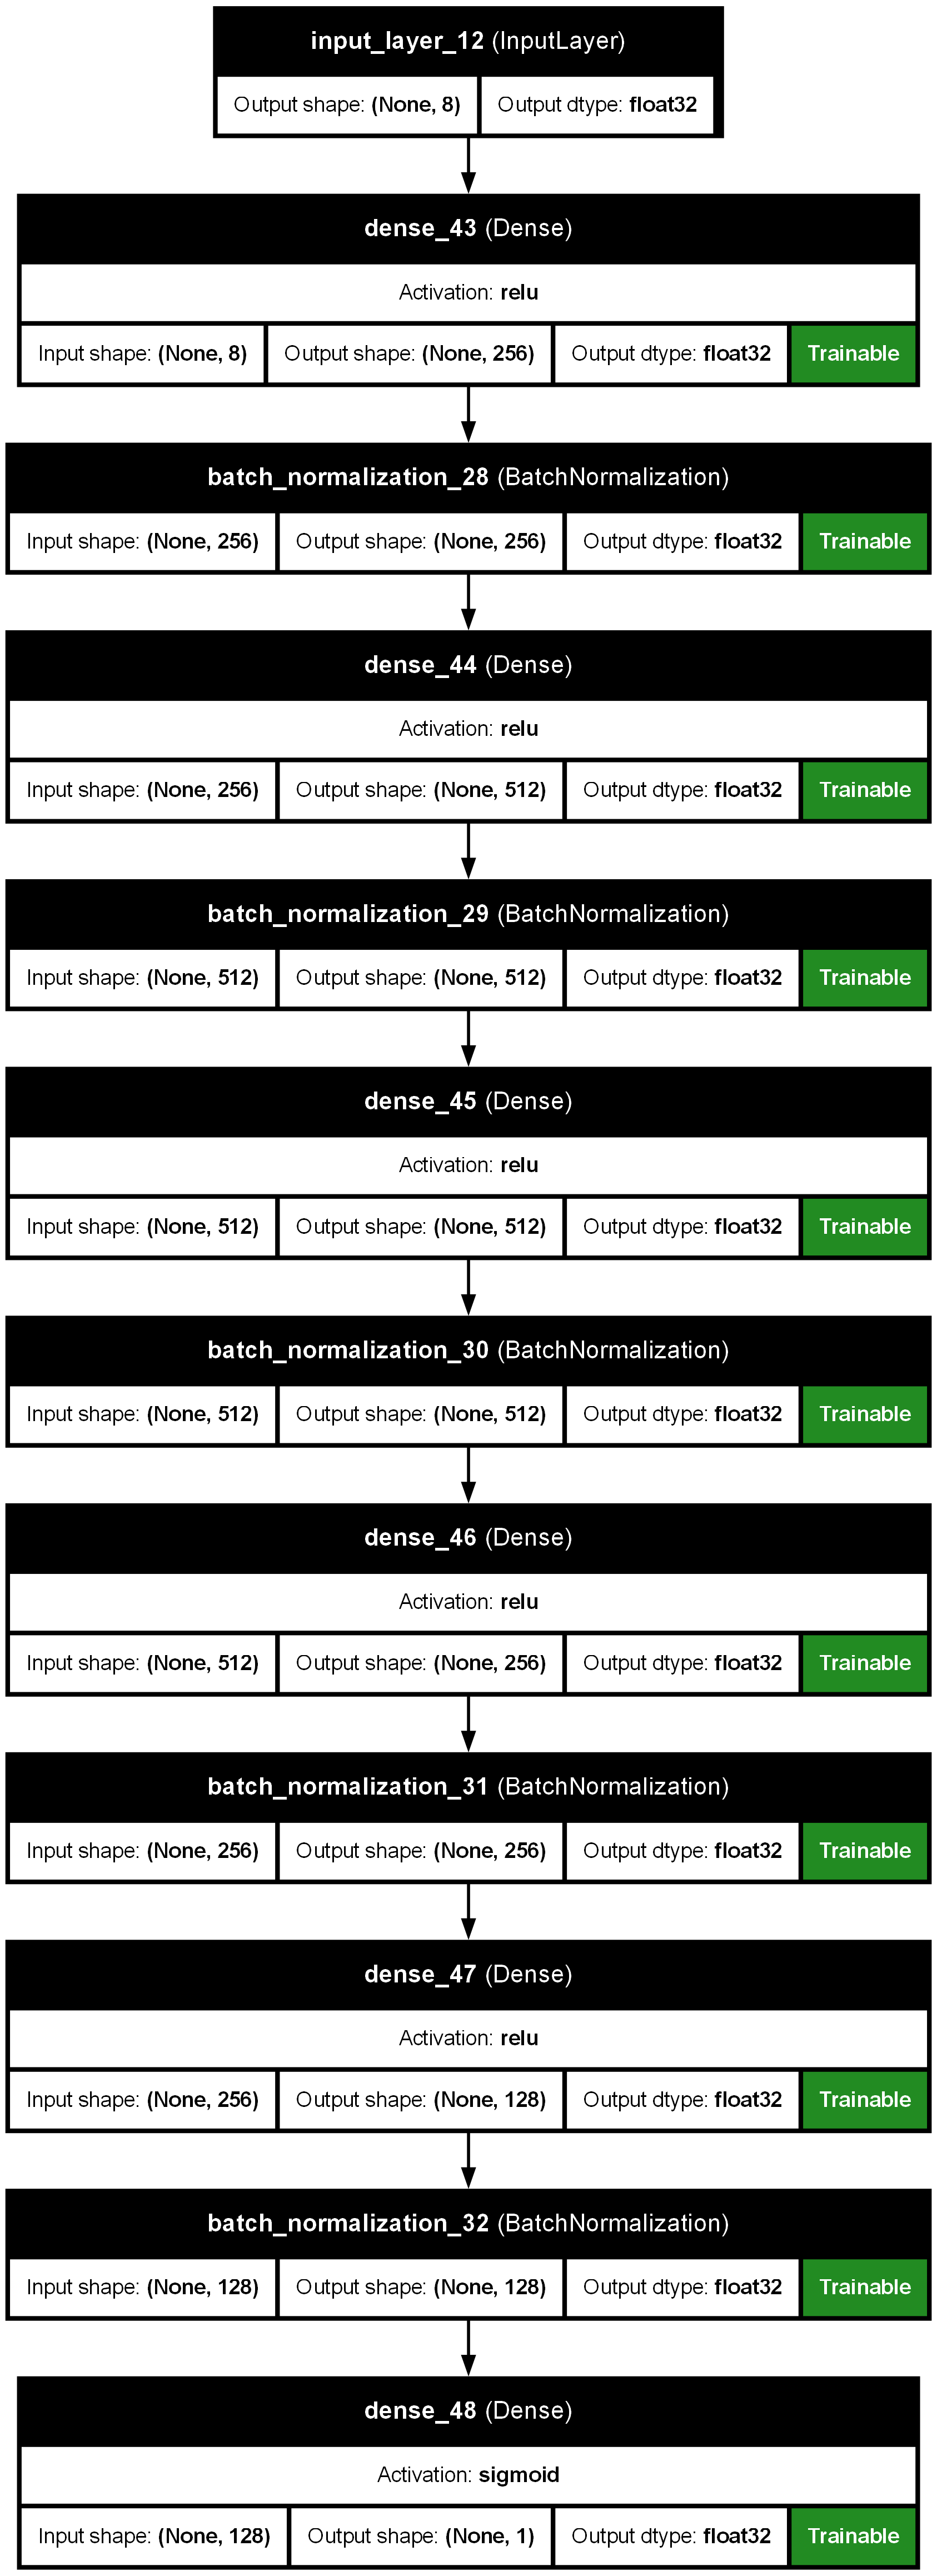

In [410]:
img_file = 'fpcheckpoint2/checkpoints_it_11/model.png'
tf.keras.utils.plot_model(model, to_file=img_file, dpi=200, show_shapes=True, show_dtype=True, show_layer_names=True,show_layer_activations=True, show_trainable=True)

#### Plot confusion matrix

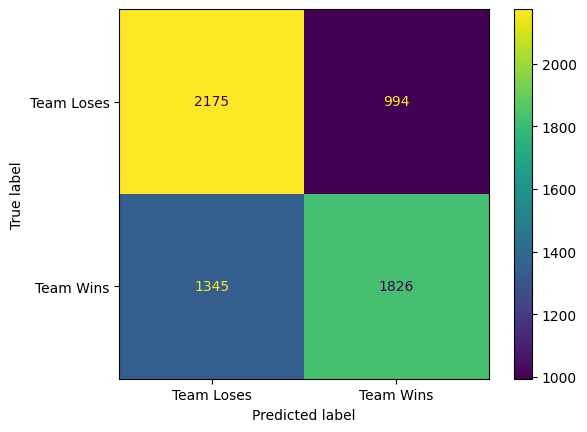

In [411]:
cm = metrics.confusion_matrix(test_y, y_pred)  # Compute confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Team Loses', 'Team Wins'])

cm_display.plot()
plt.savefig("fpcheckpoint2/checkpoints_it_11/confmatrix.jpg", dpi=300, bbox_inches='tight')
plt.show() 